In [1]:
import hnn_core
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

In [2]:
#fparams = "param_files/default.param"
fparams = "param_files/TEP_from_def_Liz_2newInputs_optimized_TMS100.param"
params = read_params(fparams)
#print(params)
#print(len(params))

In [3]:
tep_evoked = ['dist_1', 'dist_2', 'dist_3', 'prox_1', 'prox_2', 'prox_3']
erp_evoked = ['dist_4', 'prox_4', 'prox_5']

TMS_intensity_base = 80 # %MT for original data
# Scaling factors for a range of %MT
mts = [80, 100, 120]
TMS_intensity_scalars = [mt/TMS_intensity_base for mt in mts]
print(TMS_intensity_scalars)

params_list = [deepcopy(params), deepcopy(params), deepcopy(params)]

for par, scalar in zip(params_list, TMS_intensity_scalars):
    for p in par.keys():
        if any([f'gbar_ev{tep}' in p for tep in tep_evoked]):
            par[p] *= scalar
    #print(par)

#print(params_list)

[1.0, 1.25, 1.5]


In [4]:
# [net80, net100, net120]
nets = [calcium_model(params=par, add_drives_from_params=True) for par in params_list]

In [5]:
# [dpls80, dpls100, dpls120]
dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=3) for net in nets]
#print(dpls_list)

Joblib will run 3 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from c:\Users\jacob\anaconda3\Lib\site-packages\hnn_core\mod\nrnmech.dll
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Building the NEURON model
[Done]
Trial 2: 0.03 ms...
Trial 2: 10.0 ms...
Trial 2: 20.0 ms...
Trial 2: 30.0 ms...
Trial 2: 40.0 ms...
Trial 2: 50.0 ms...
Trial 2: 60.0 m

In [6]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    #plt.show(fig)

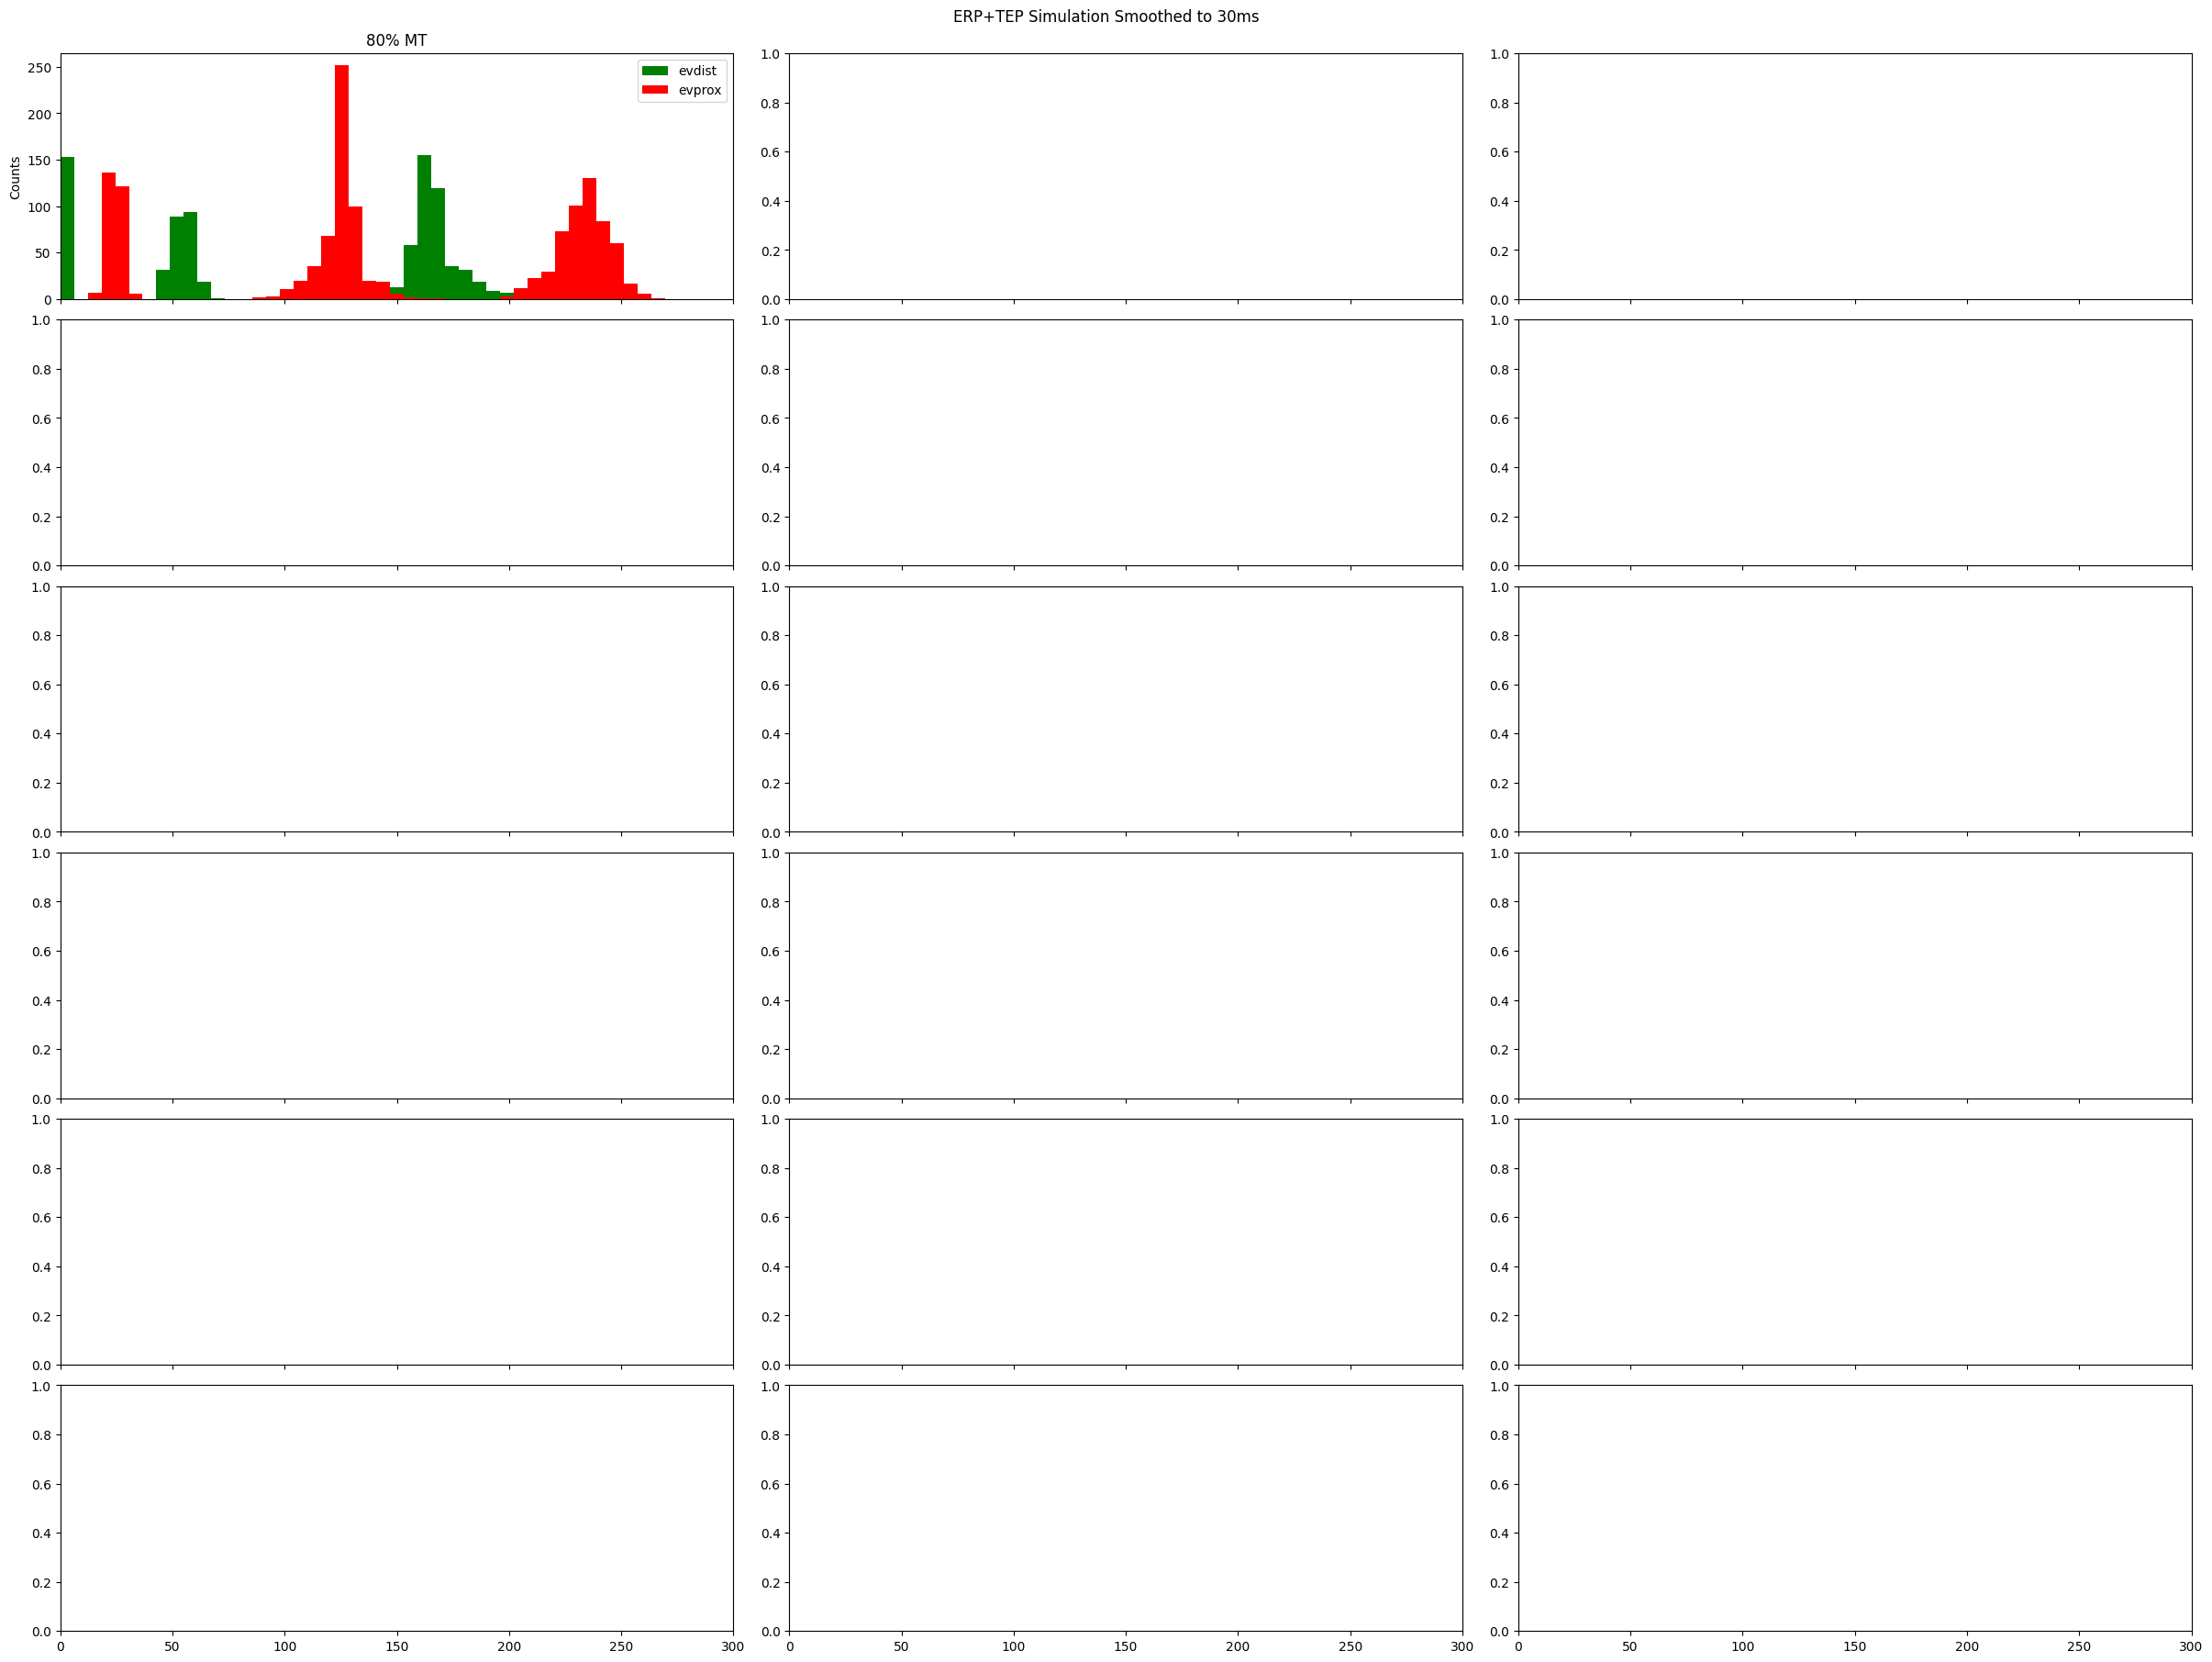

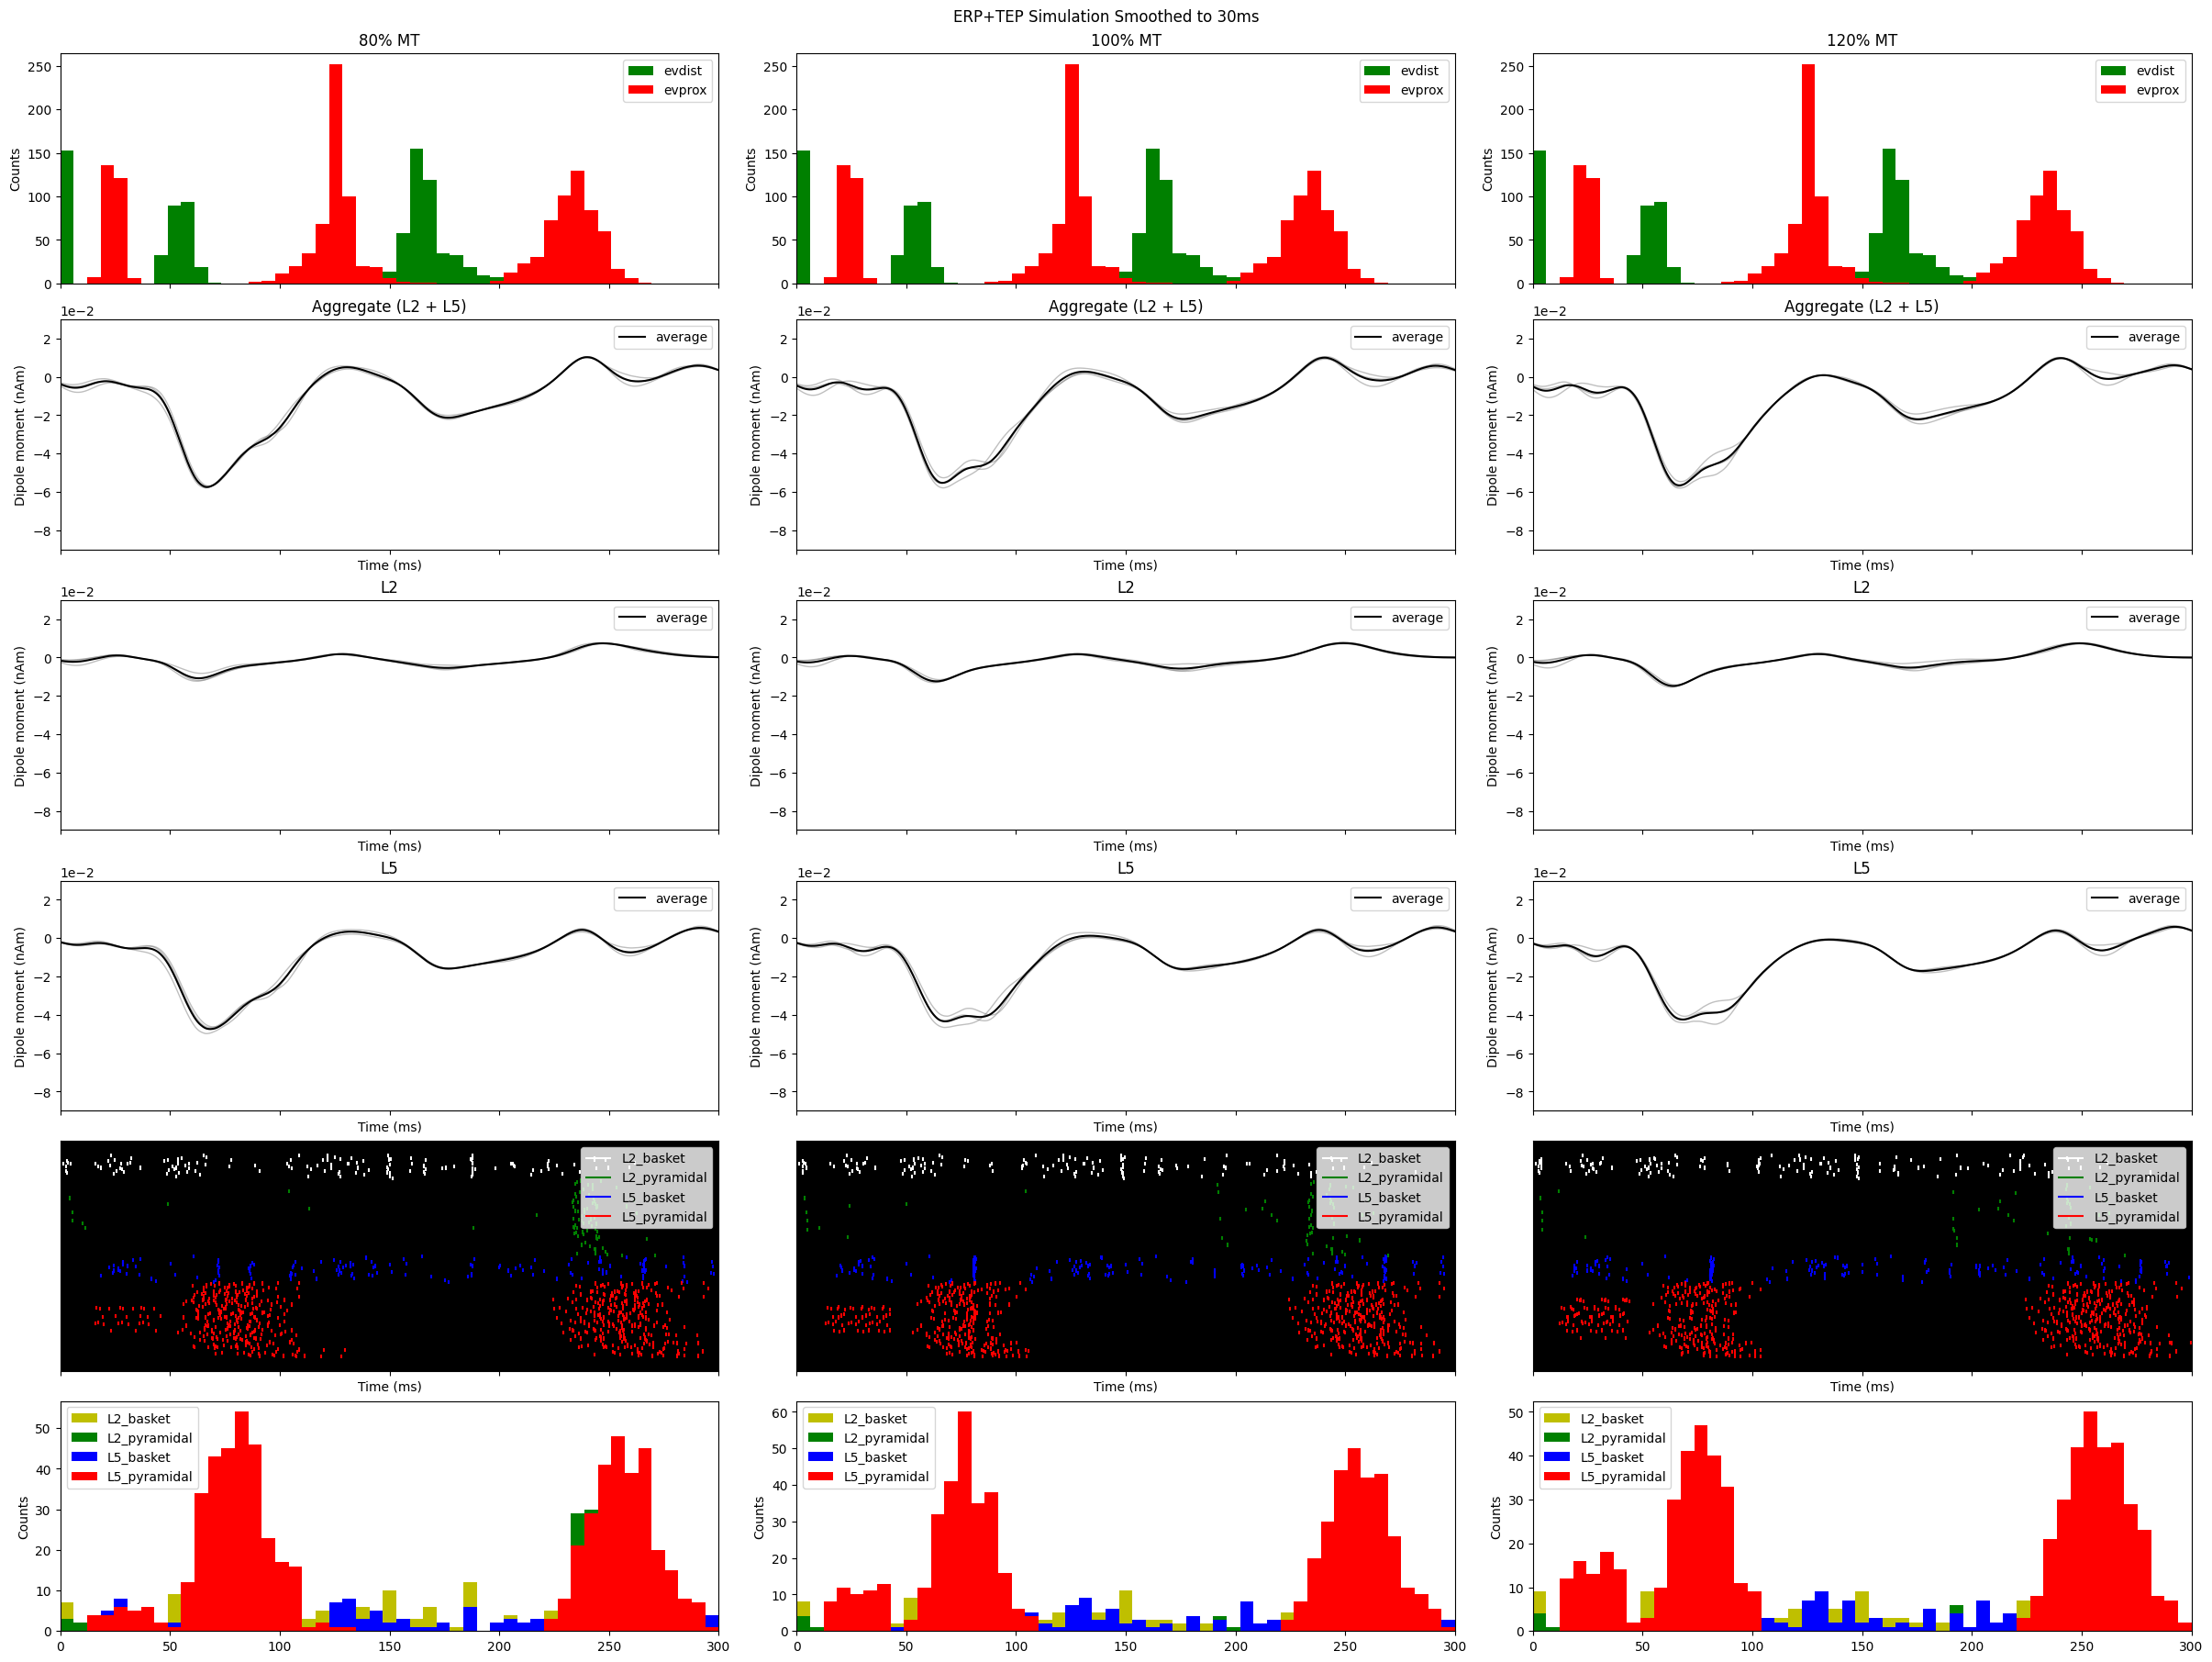

In [7]:
window_len = 30 # ms
scaling_factor = 1#3000
dpls_list_smoothed = deepcopy(dpls_list)
for dpls in dpls_list_smoothed:
    for dpl in dpls:
        dpl.smooth(window_len).scale(scaling_factor)

fig, axes = plt.subplots(6, 3, sharex=True, figsize=(24, 18), constrained_layout=True)
fig.suptitle('ERP+TEP Simulation Smoothed to 30ms')

for i in range(len(nets)):
    dpls = dpls_list_smoothed[i]
    ylim = [-9e-2, 3e-2]
    
    axes[0][i].set_title(f'{mts[i]}% MT')
    nets[i].cell_response.plot_spikes_hist(ax=axes[0][i], spike_types=['evprox', 'evdist'], trial_idx=0)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[1][i], layer='agg', show=False, average=True)
    axes[1][i].set_ylim(ylim)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[2][i], layer='L2', show=False, average=True)
    axes[2][i].set_ylim(ylim)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[3][i], layer='L5', show=False, average=True)
    axes[3][i].set_ylim(ylim)
    nets[i].cell_response.plot_spikes_raster(ax=axes[4][i], trial_idx=0)
    nets[i].cell_response.plot_spikes_hist(ax=axes[5][i], spike_types=['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket', ], trial_idx=0)
    
show_figure(fig)


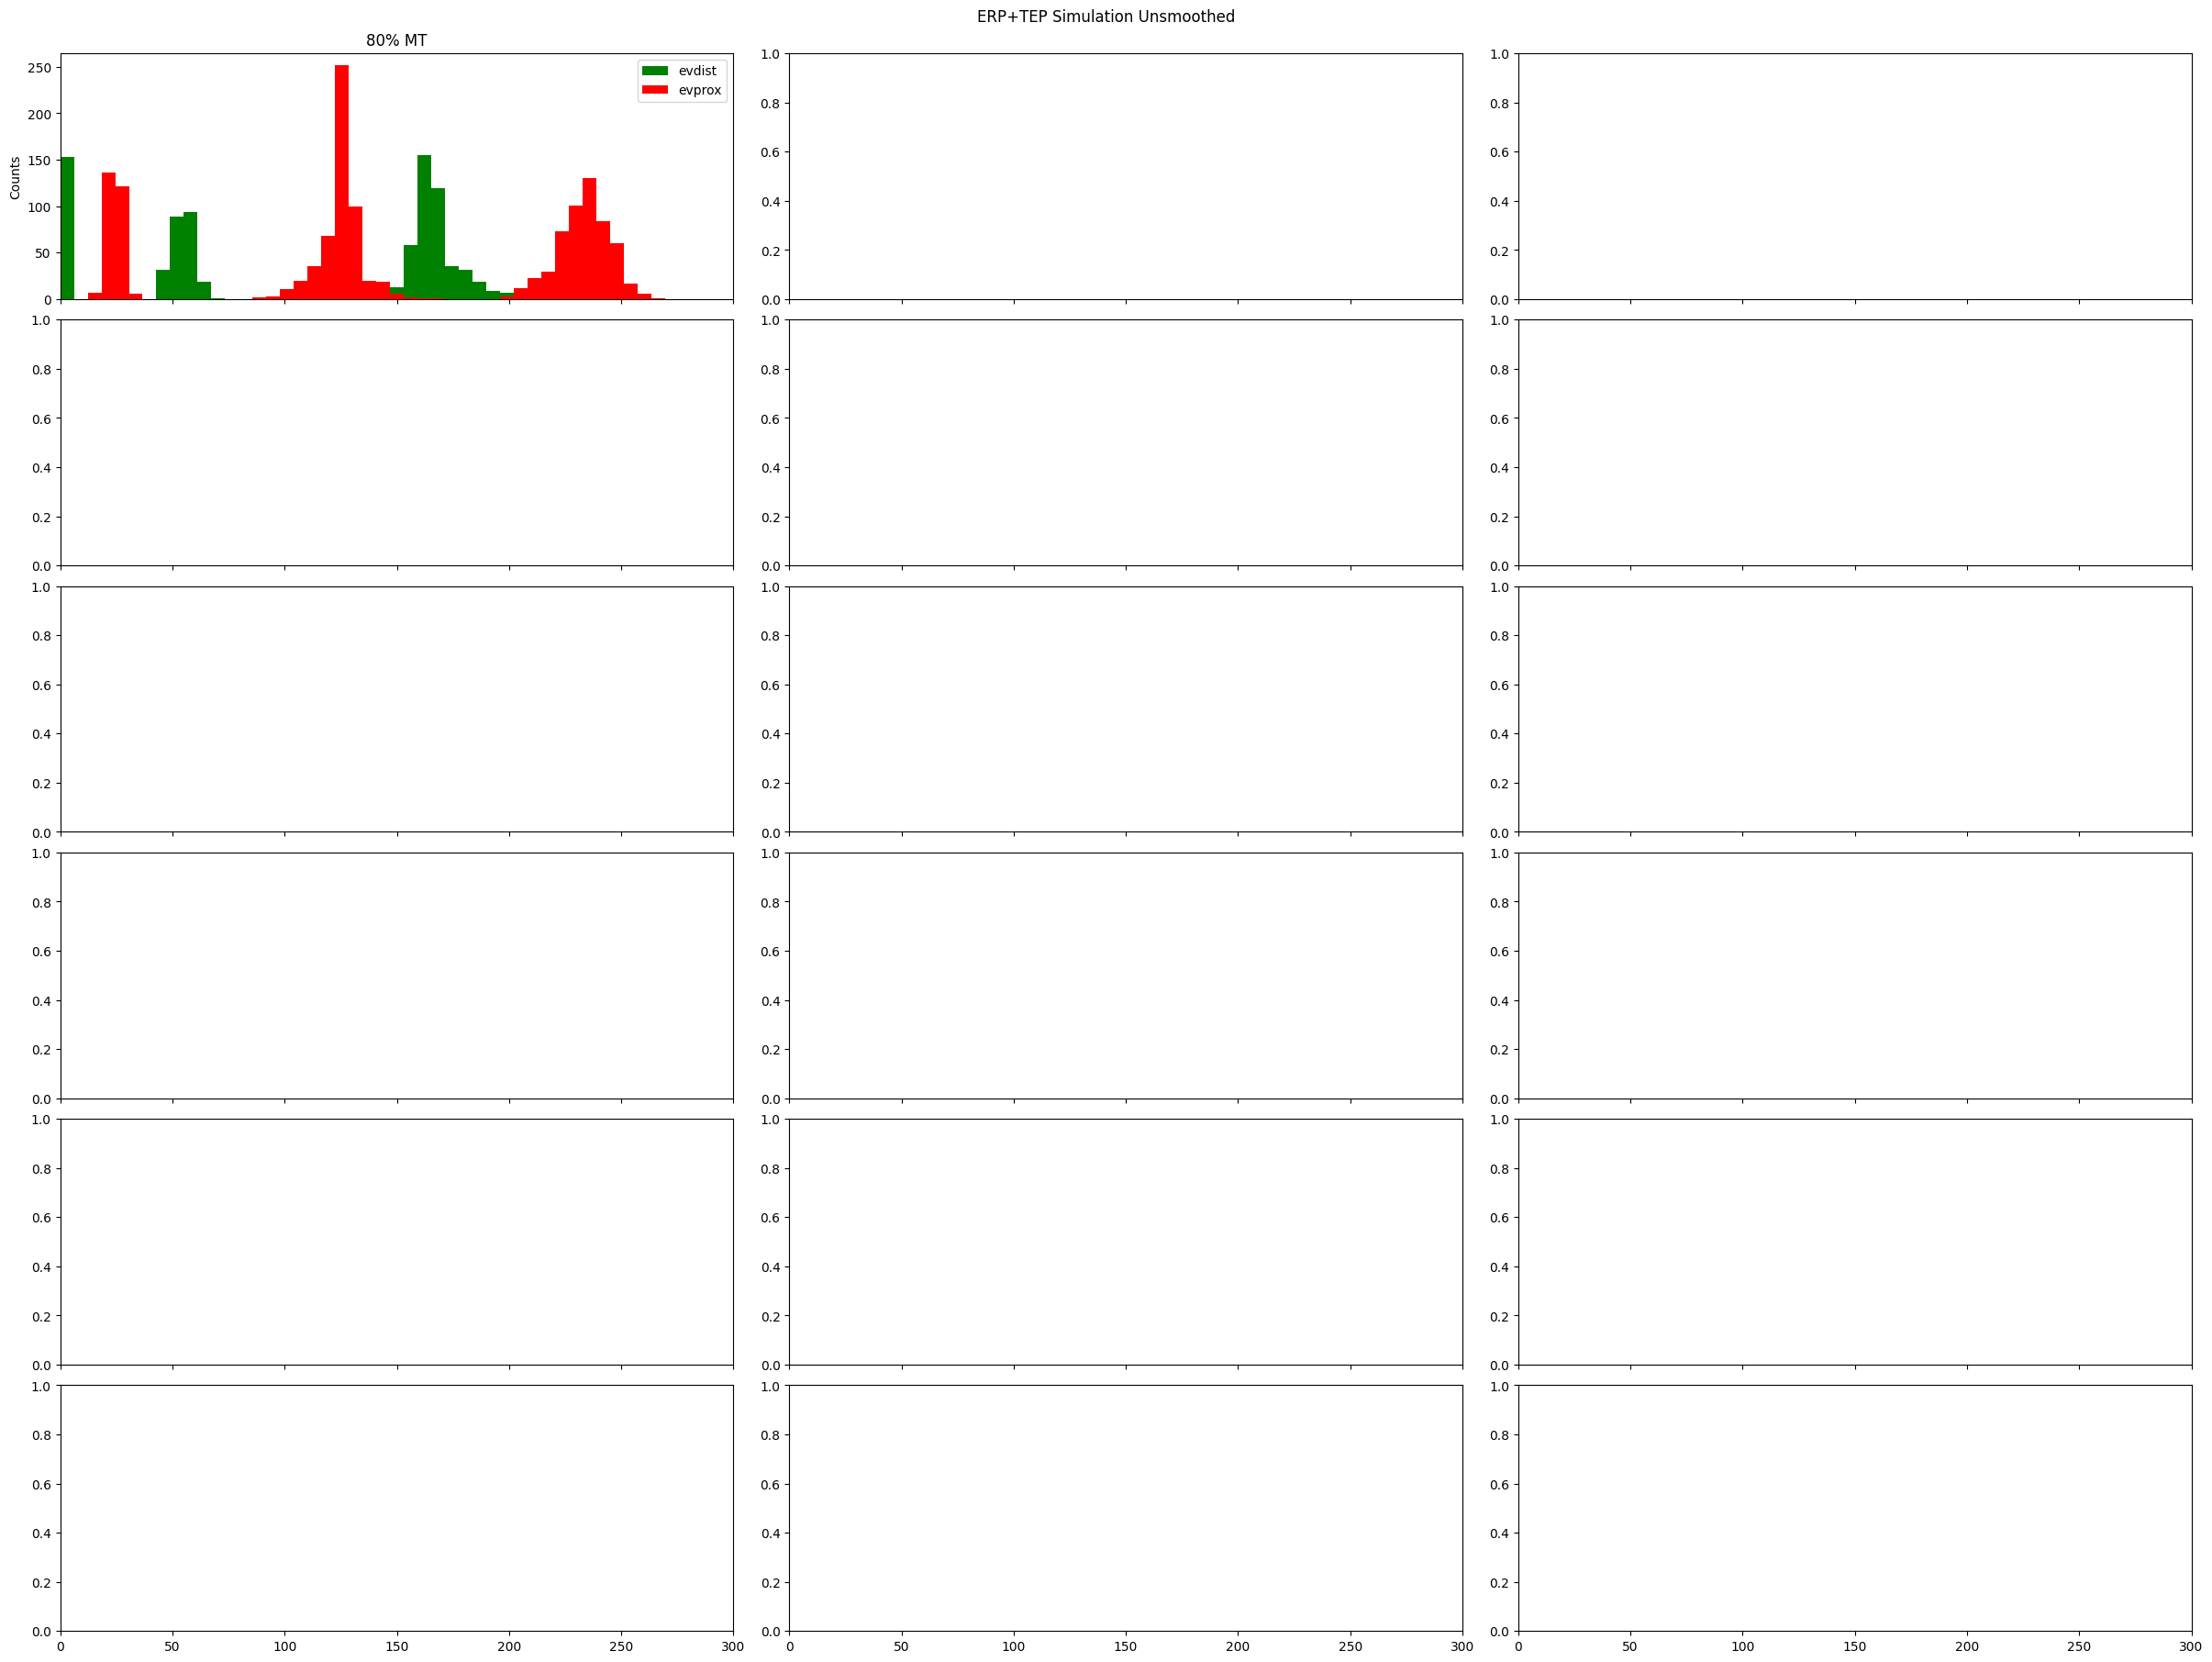

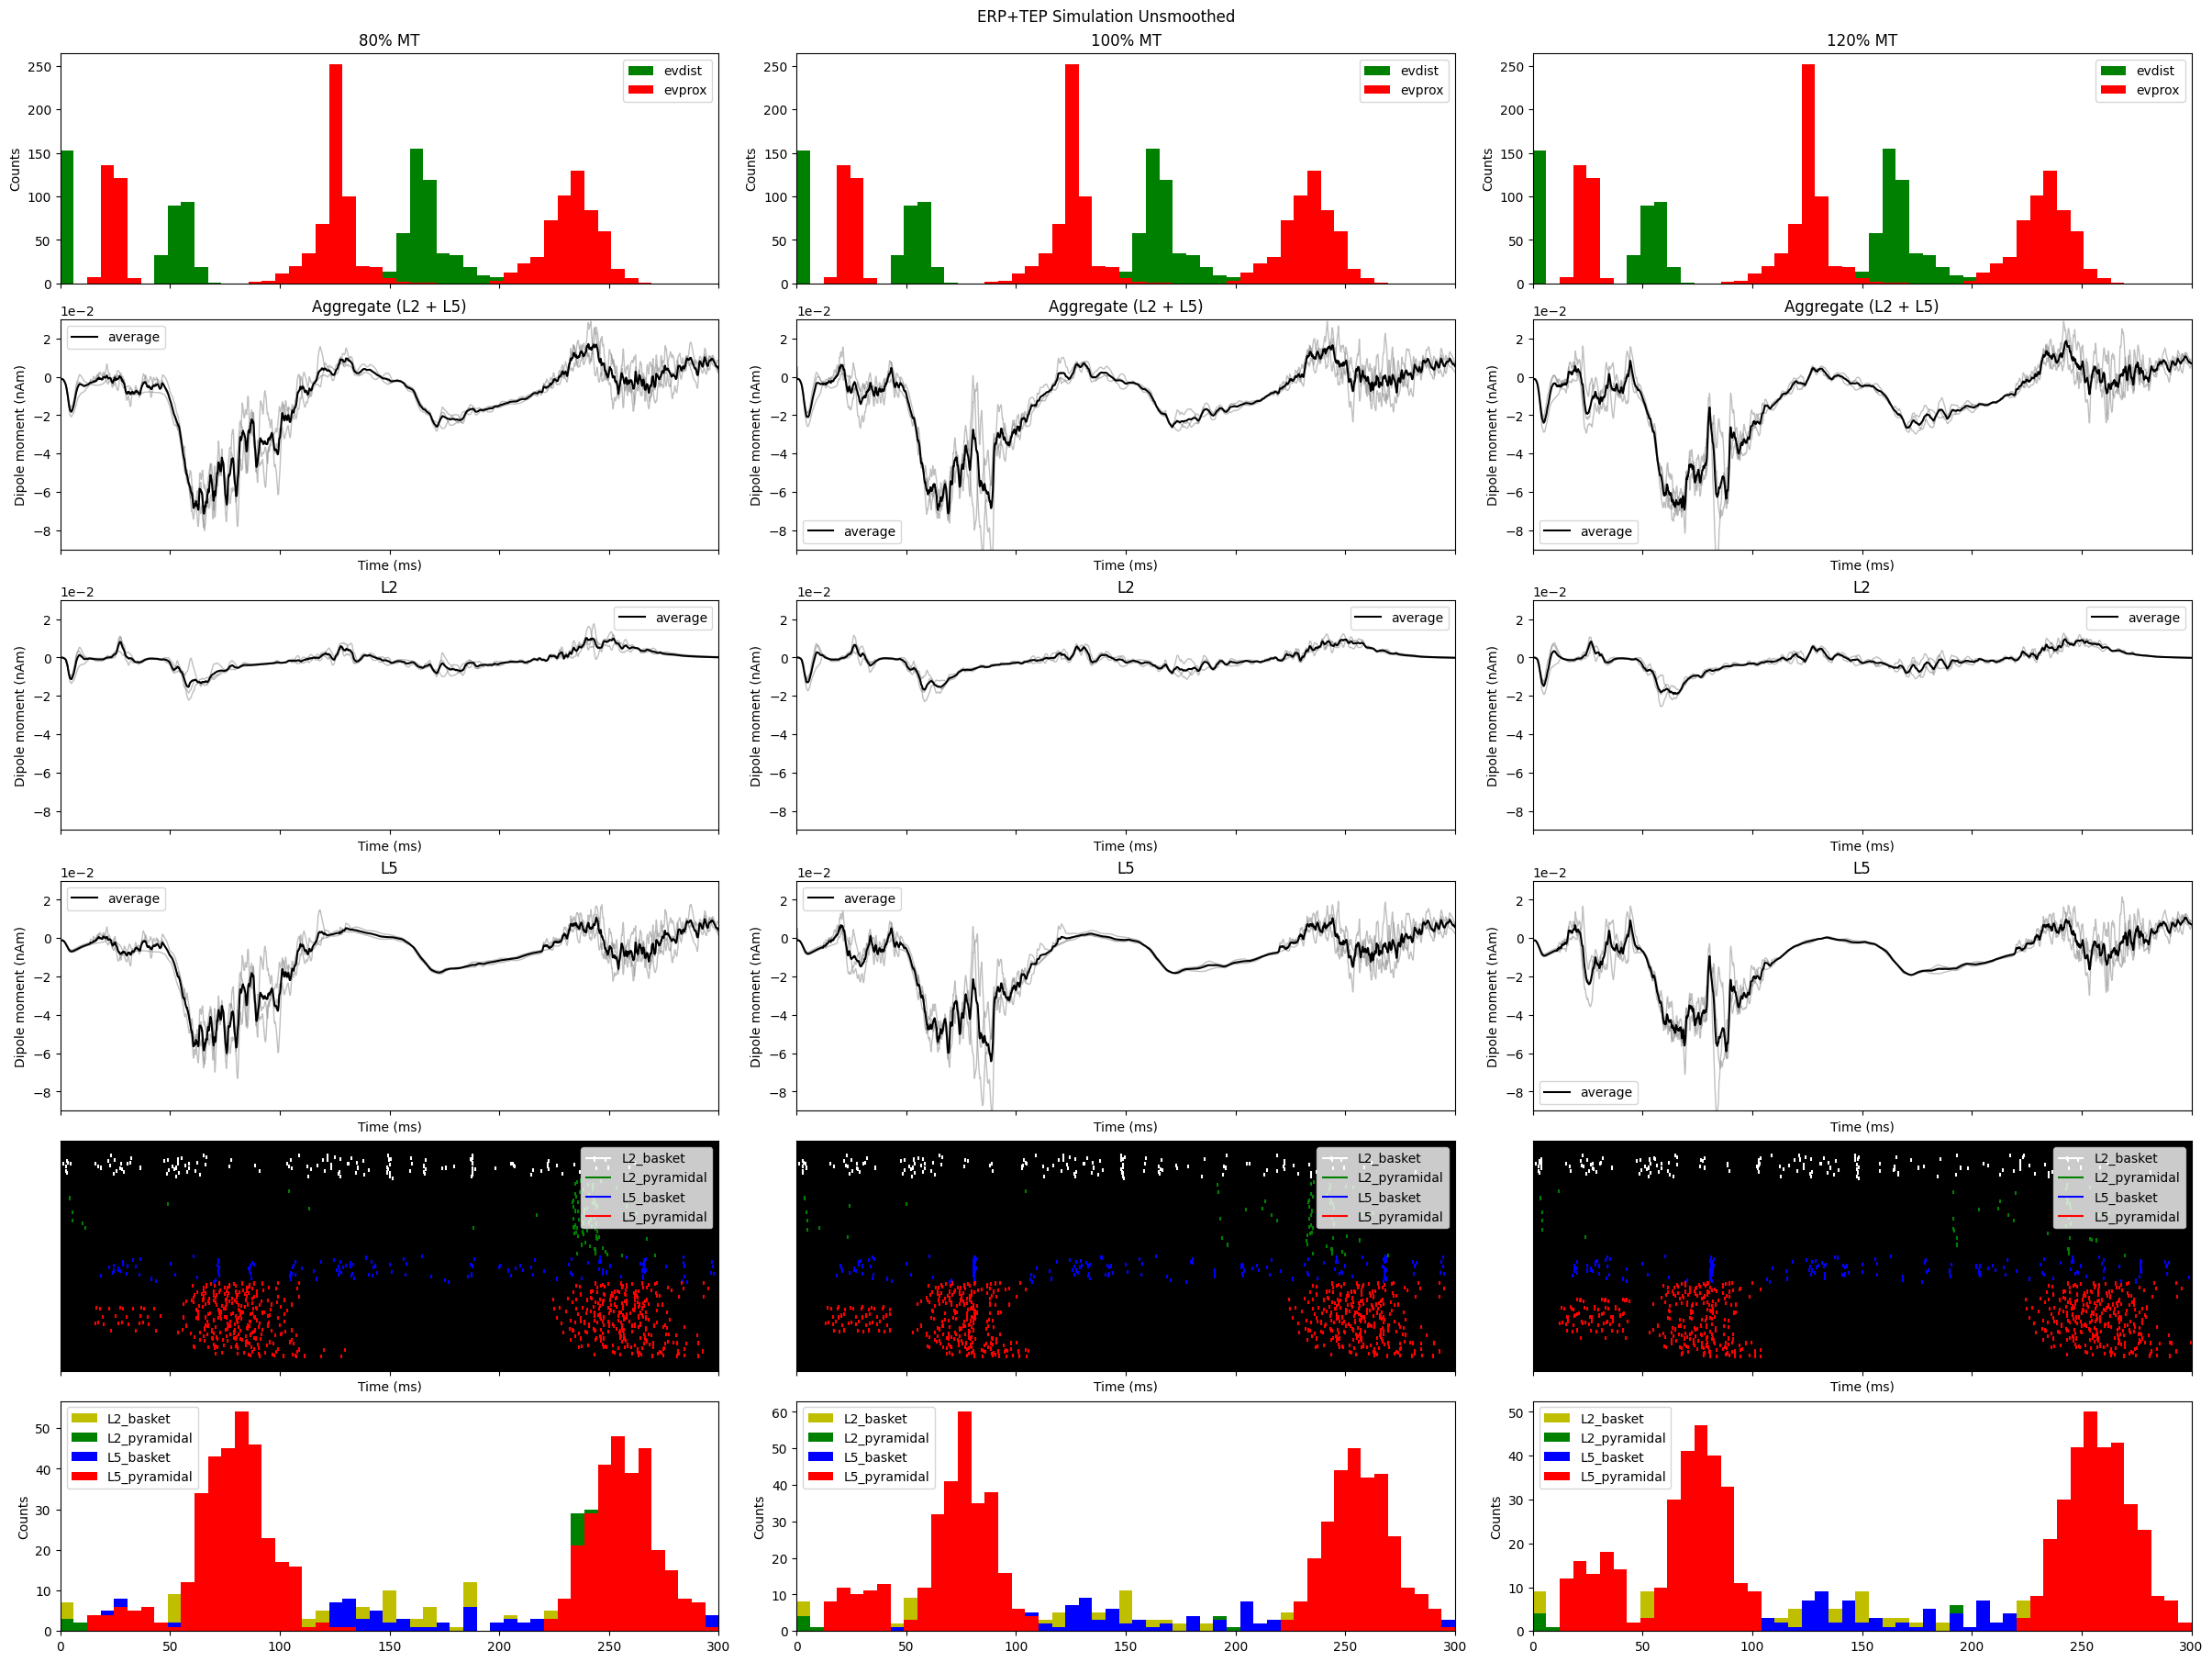

In [8]:
dpls_list_unsmoothed = deepcopy(dpls_list)

fig, axes = plt.subplots(6, 3, sharex=True, figsize=(24, 18), constrained_layout=True)
fig.suptitle('ERP+TEP Simulation Unsmoothed')

for i in range(len(nets)):
    dpls = dpls_list_unsmoothed[i]
    ylim = [-9e-2, 3e-2]
    
    axes[0][i].set_title(f'{mts[i]}% MT')
    nets[i].cell_response.plot_spikes_hist(ax=axes[0][i], spike_types=['evprox', 'evdist'], trial_idx=0)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[1][i], layer='agg', show=False, average=True)
    axes[1][i].set_ylim(ylim)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[2][i], layer='L2', show=False, average=True)
    axes[2][i].set_ylim(ylim)
    dpls_copy = deepcopy(dpls)
    plot_dipole(dpls_copy, ax=axes[3][i], layer='L5', show=False, average=True)
    axes[3][i].set_ylim(ylim)
    nets[i].cell_response.plot_spikes_raster(ax=axes[4][i], trial_idx=0)
    nets[i].cell_response.plot_spikes_hist(ax=axes[5][i], spike_types=['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket', ], trial_idx=0)
    
show_figure(fig)

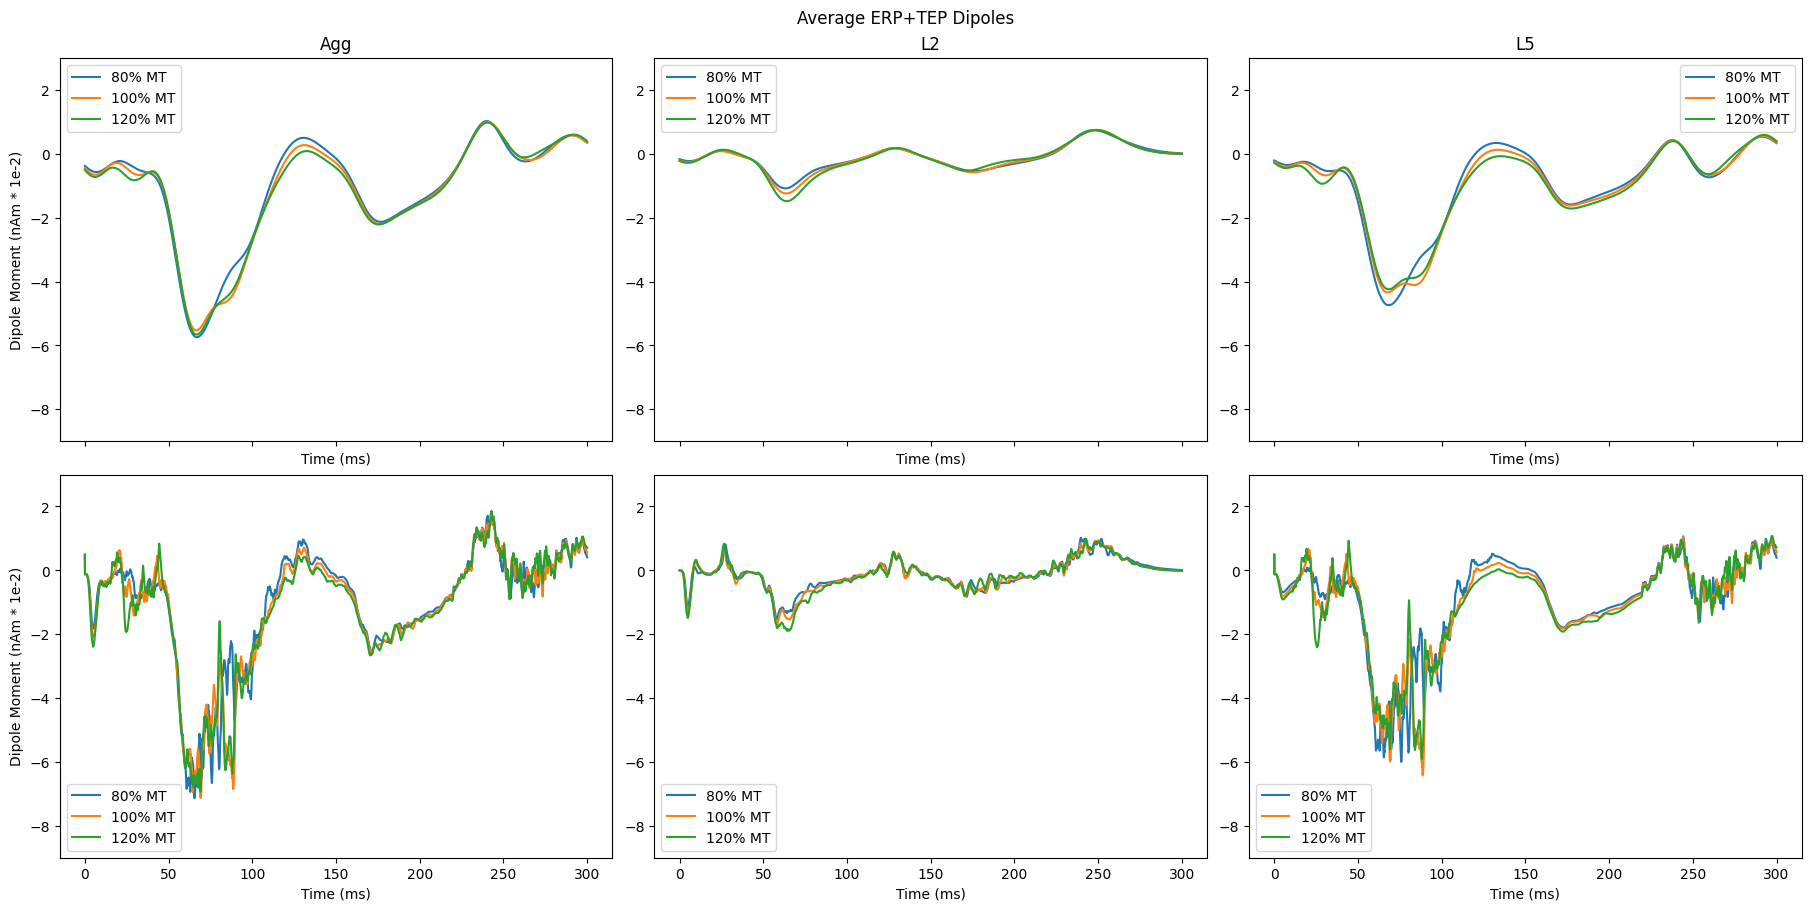

In [10]:
# from hnn_core import average_dipoles
# print(dpls_list_smoothed)
avg_dipoles_smoothed = [average_dipoles(dpls) for dpls in dpls_list_smoothed]
avg_dipoles_unsmoothed = [average_dipoles(dpls) for dpls in dpls_list_unsmoothed]

fig, axes = plt.subplots(2, 3, sharex=True, figsize=(18, 9), constrained_layout=True)
fig.suptitle("Average ERP+TEP Dipoles")
for i, title in enumerate(["Agg", "L2", "L5"]):
    axes[0][i].set_title(title)
for ax in axes:
    ax[0].set_ylabel("Dipole Moment (nAm * 1e-2)")

for i, avg_dpls in enumerate([avg_dipoles_smoothed, avg_dipoles_unsmoothed]):
    for j, layer in enumerate(["agg", "L2", "L5"]):
        for dpl in avg_dpls:
            axes[i][j].plot(dpl.times, dpl.data[layer]*1e2)
        axes[i][j].legend(["80% MT", "100% MT", "120% MT"])
        axes[i][j].set_xlabel("Time (ms)")
        axes[i][j].set_ylim([-9, 3])

# for dpl in avg_dipoles_unsmoothed:
#     axes[1].plot(dpl.times, dpl.data["agg"]*1e2)
# axes[1].set_title("Average Dipoles Unsmoothed")
# axes[1].legend(["80% MT", "100% MT", "120% MT"])
# axes[1].set_xlabel("Time (ms)")
# axes[1].set_ylabel("Dipole Moment (nAm * 1e-2)")
# axes[1].set_ylim([-8, 1])
